In [3]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import seaborn as sns

C:\Users\hp\anaconda3\envs\time_series\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Reading Data

In [4]:
%matplotlib inline
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [3]:
# !pip install openpyxl

In [5]:
df = pd.read_excel('../data/Prices.xlsx', sheet_name='Daily', skiprows=8, usecols='D:E', index_col='Name')
df.index

DatetimeIndex(['1978-12-29', '1979-01-01', '1979-01-02', '1979-01-03',
               '1979-01-04', '1979-01-05', '1979-01-08', '1979-01-09',
               '1979-01-10', '1979-01-11',
               ...
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-11', '2022-04-12', '2022-04-13',
               '2022-04-14', '2022-04-15'],
              dtype='datetime64[ns]', name='Name', length=11296, freq=None)

In [6]:
df.head()

,US dollar
Name,
1978-12-29,226.00
1979-01-01,226.00
1979-01-02,226.80
1979-01-03,218.60
1979-01-04,223.15


In [5]:
df.index # already a datetime index

DatetimeIndex(['1978-12-29', '1979-01-01', '1979-01-02', '1979-01-03',
               '1979-01-04', '1979-01-05', '1979-01-08', '1979-01-09',
               '1979-01-10', '1979-01-11',
               ...
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-11', '2022-04-12', '2022-04-13',
               '2022-04-14', '2022-04-15'],
              dtype='datetime64[ns]', name='Name', length=11296, freq=None)

### Visualization and Analytics

             US dollar
Name                  
1978-12-31  226.000000
1979-01-31  227.215217
1979-02-28  245.670000
1979-03-31  242.047727
1979-04-30  238.664286


<AxesSubplot:xlabel='Name'>

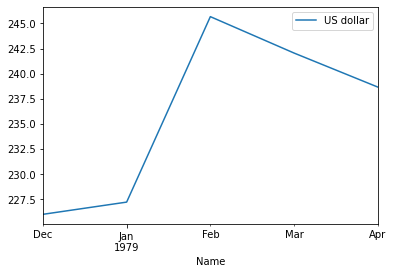

In [7]:
# Mean value at the end of month
print(df.resample(rule='M').mean().head())
df.resample(rule='M').mean().head().plot() # 1978 Dec - 1979 April

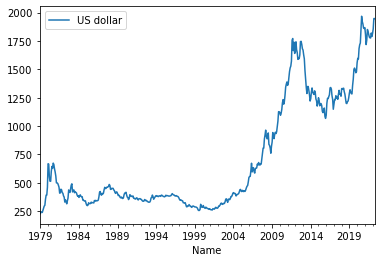

In [8]:
df.resample(rule='M').mean().plot(); # 1978 Dec-Curr

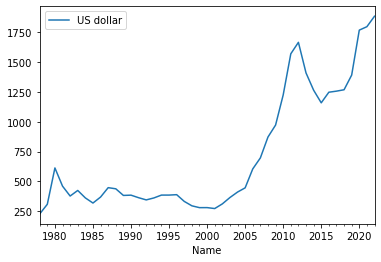

In [9]:
df.resample(rule='AS').mean().plot(); # year start resample, less noise

In [10]:
df.rolling(window=30).mean()[30:] # rolling average of every month

,US dollar
Name,
1979-02-09,230.735000
1979-02-12,231.343333
1979-02-13,231.803333
1979-02-14,232.538333
1979-02-15,233.358333
...,...
2022-04-11,1945.310000
2022-04-12,1946.605000
2022-04-13,1948.213333


<AxesSubplot:xlabel='Name'>

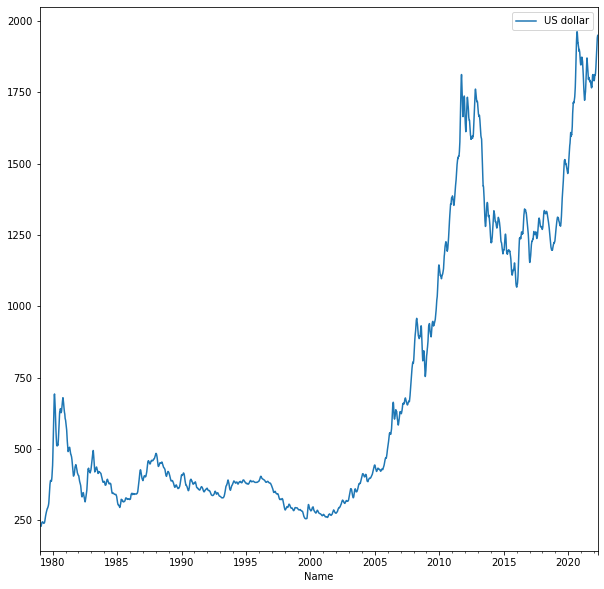

In [11]:
df.rolling(window=30).mean().plot(figsize=(10,10)) # rolling average of every month

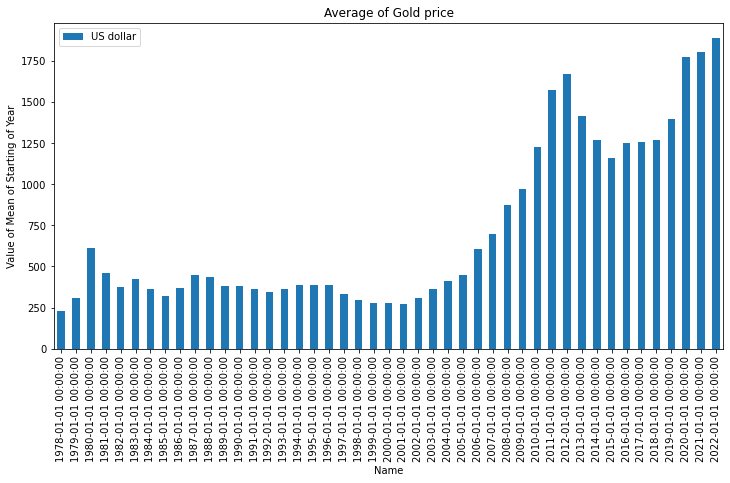

In [12]:
ax = df.resample(rule='AS').mean().plot.bar(figsize=(12,6))
ax.set(title='Average of Gold price', ylabel='Value of Mean of Starting of Year');

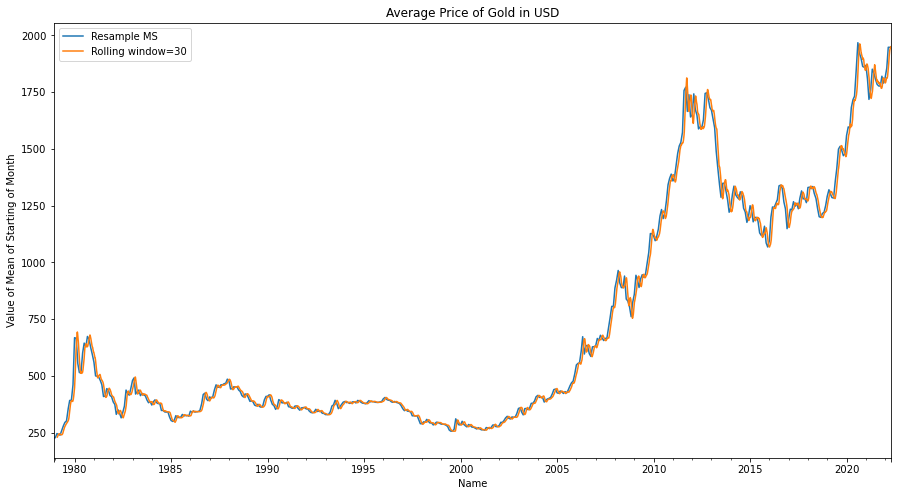

In [13]:
ax = df['US dollar'].resample(rule='M').mean().plot(figsize=(15,8), label='Resample MS')
ax.autoscale(tight=True)
df.rolling(window=30).mean()['US dollar'].plot(label='Rolling window=30')

ax.set(ylabel='Value of Mean of Starting of Month',title='Average Price of Gold in USD')
ax.legend()

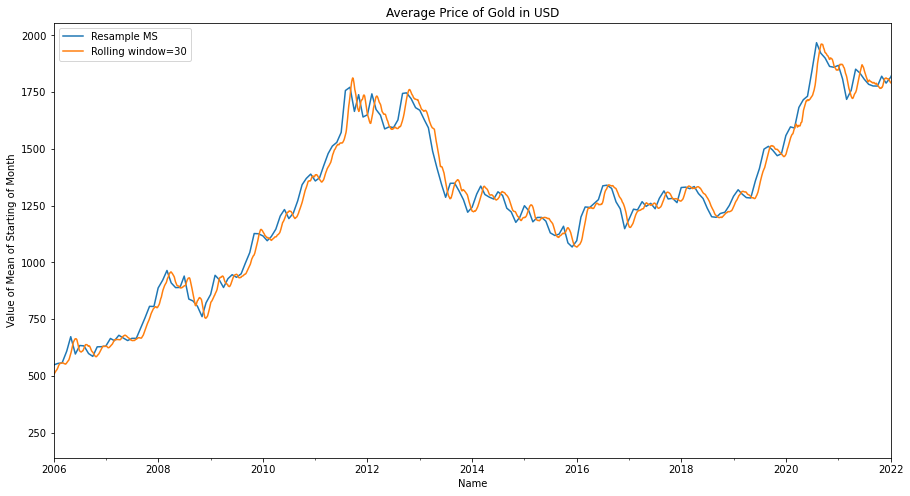

In [14]:
# rolling mean from 2006, till 2020 to check the spike and decrease.

ax = df['US dollar'].resample(rule='M').mean().plot(xlim=['2006-01-01','2022-01-01'], figsize=(15,8), label='Resample MS')
ax.autoscale(tight=True)
df.rolling(window=30).mean()['US dollar'].plot(xlim=['2006-01-01','2022-01-01'],label='Rolling window=30')

ax.set(ylabel='Value of Mean of Starting of Month',title='Average Price of Gold in USD')
ax.legend()

#### Dollar Price moving avg every 1 year vs every 5 year

<AxesSubplot:xlabel='ds'>

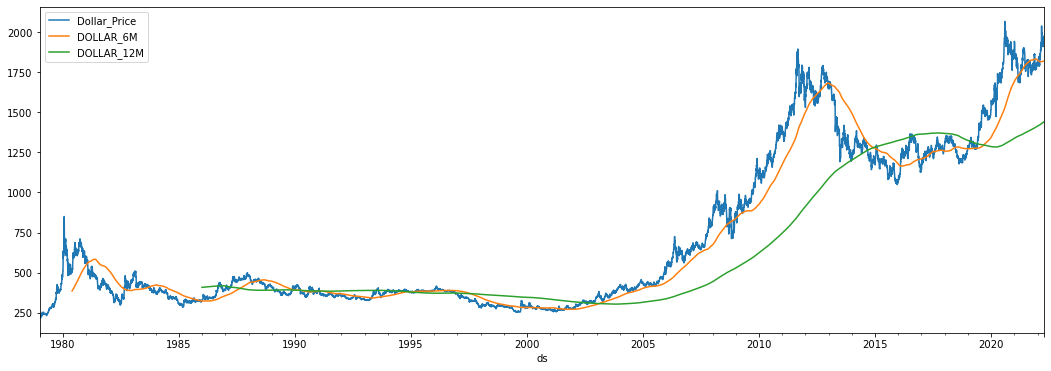

In [27]:
df['DOLLAR_6M'] = df['Dollar_Price'].rolling(window=365).mean()
df['DOLLAR_12M'] = df['Dollar_Price'].rolling(window=365*5+1).mean()
df[['Dollar_Price','DOLLAR_6M','DOLLAR_12M']].plot(figsize=(18,6))

In [30]:
del  df['DOLLAR_12M'],df['DOLLAR_6M']

# Models
* ARIMA
* FBProphet
* Bi-directional LSTM
* Pycaret

* ### FBProphet

In [15]:
# !pip install fbprophet

In [16]:
prophet_model = Prophet(interval_width=0.95)

In [6]:
# renaming for fbprophet
df.rename_axis('ds', inplace=True)
df.rename(columns={'US dollar':'y'}, inplace=True)
df.reset_index(inplace=True) 

df.head()

,ds,y
0,1978-12-29,226.00
1,1979-01-01,226.00
2,1979-01-02,226.80
3,1979-01-03,218.60
4,1979-01-04,223.15


In [18]:
prophet_model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### predictions

In [19]:
future_dataset= prophet_model.make_future_dataframe(periods=15, freq='y') # 15 YEARS OF DATA

In [20]:
future_dataset.tail()

,ds
11306,2032-12-31
11307,2033-12-31
11308,2034-12-31
11309,2035-12-31
11310,2036-12-31


In [21]:
pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,1978-12-29,198.190717,37.649574,350.666259
1,1979-01-01,202.610300,34.265326,375.458218
2,1979-01-02,204.201136,35.816410,362.521922
3,1979-01-03,205.976840,42.288406,362.155616
4,1979-01-04,207.627541,52.584523,371.711477


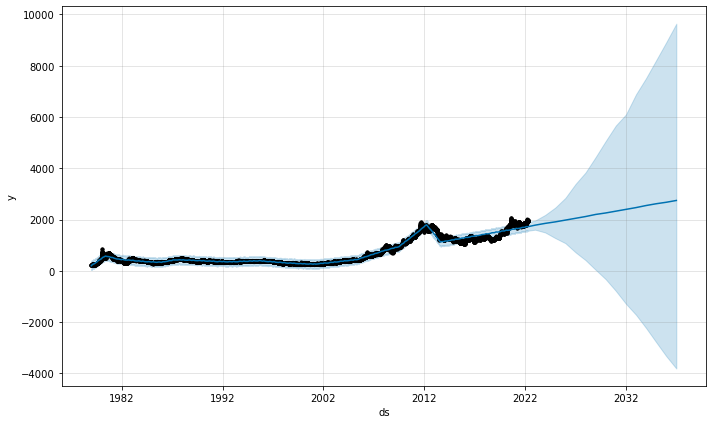

In [22]:
prophet_model.plot(pred);

In [23]:
date_pred='2030-12-12'

In [24]:
date = pd.DataFrame({'ds':pd.date_range(start=date_pred, end=date_pred)})

date.head()

,ds
0,2030-12-12


In [25]:
pred = prophet_model.predict(date)

In [26]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2030-12-12,2330.335897,-818.836881,5571.555966,-864.922215,5654.791374,-9.169629,-9.169629,-9.169629,-3.274349,-3.274349,-3.274349,-5.89528,-5.89528,-5.89528,0.0,0.0,0.0,2321.166269


#### saving

In [27]:
import pickle
with open('../models/fbprophet.pckl', 'wb') as fout:
    pickle.dump(prophet_model, fout)

* ### ARIMA

In [40]:
!pip install statsmodels==0.11.0 

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\hp\\anaconda3\\envs\\time_series\\lib\\site-packages\\~tatsmodels\\tsa\\innovations\\_arma_innovations.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.2
    Uninstalling statsmodels-0.13.2:
      Successfully uninstalled statsmodels-0.13.2


In [7]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [8]:
df.set_index('ds', inplace=True)
df.columns

Index(['y'], dtype='object')

In [9]:
df.rename(columns={'y':'Dollar_Price'}, inplace=True)

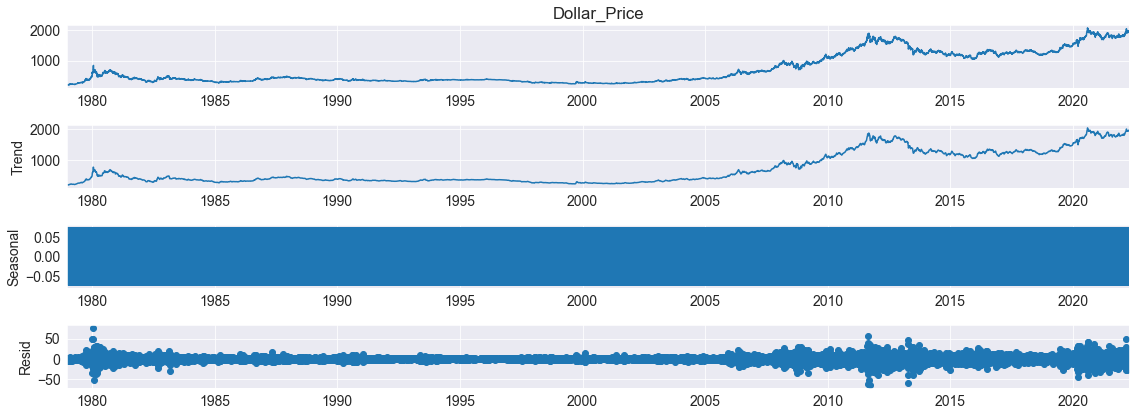

In [10]:
result_add = seasonal_decompose(df['Dollar_Price'],model = 'add')
result_add.plot(15, 6);

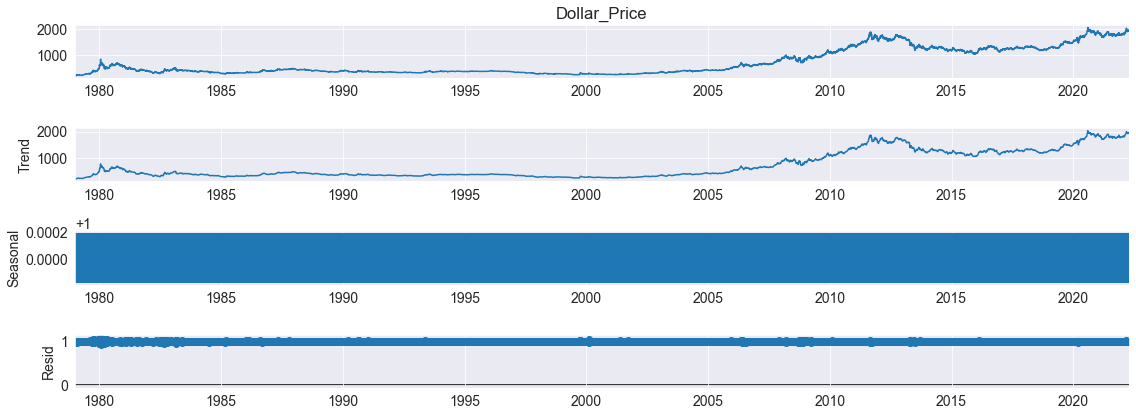

In [11]:
result_mul = seasonal_decompose(df['Dollar_Price'],model = 'mul')
result_mul.plot();

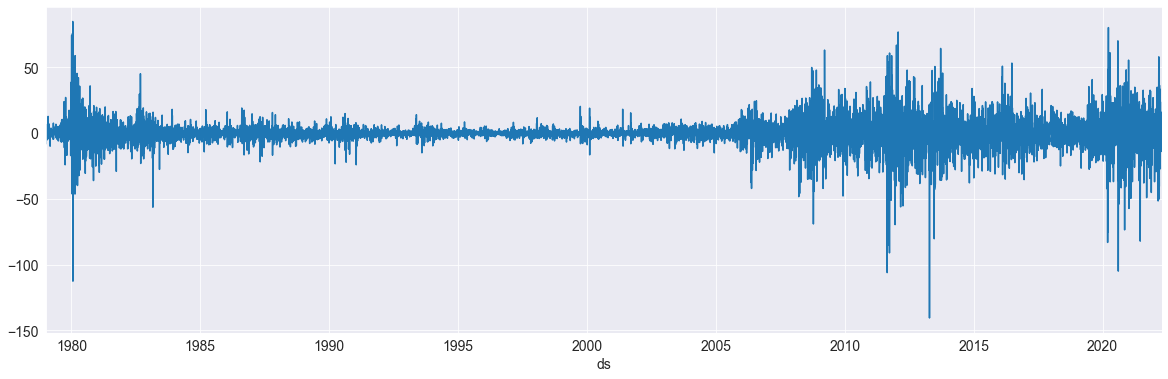

In [12]:
# 1-difference bw values

df['1difference']=df['Dollar_Price']-df['Dollar_Price'].shift(1)
 
df['1difference'].plot(figsize=(20,6));

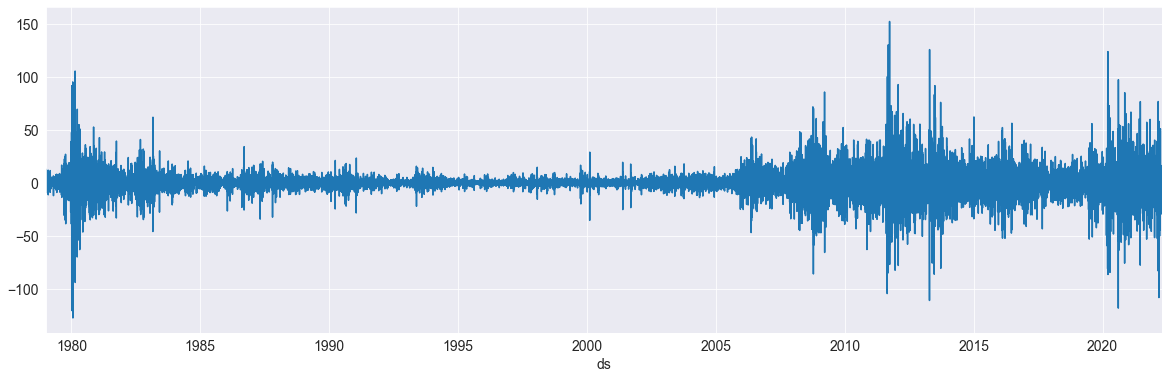

In [13]:
df['2difference']=df['1difference']-df['1difference'].shift(1)
 
df['2difference'].plot(figsize=(20, 6));

C:\Users\hp\anaconda3\envs\time_series\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


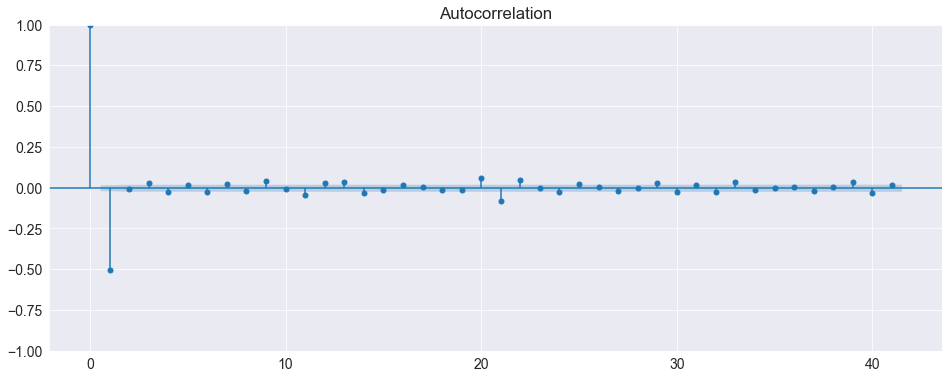

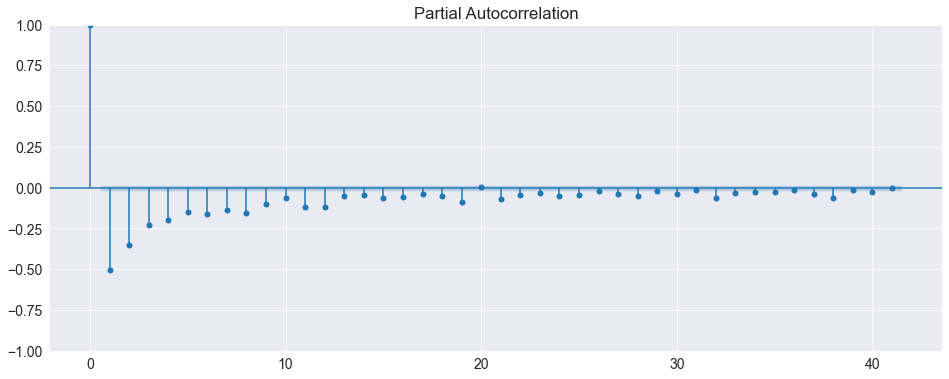

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
 
fig1=plot_acf(df['2difference'].dropna()) 
fig2=plot_pacf(df['2difference'].dropna()) 

C:\Users\hp\anaconda3\envs\time_series\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


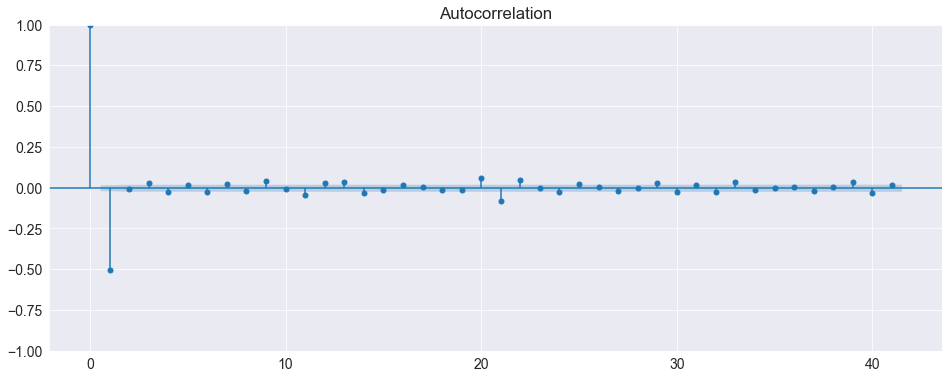

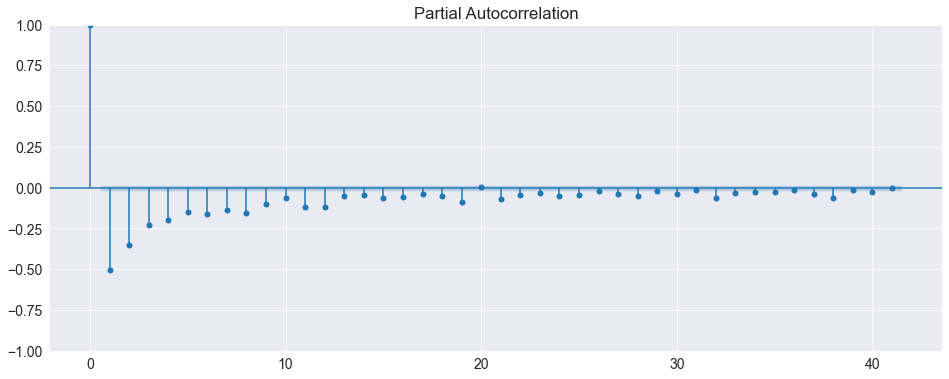

In [15]:
fig1=plot_acf(df['2difference'].dropna()) 
fig2=plot_pacf(df['2difference'].dropna()) 

In [135]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
p=d=q=r=range(0,3)
seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in list(itertools.product(p, d, q,r))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 1)
SARIMAX: (0, 0, 1) x (0, 0, 0, 2)
SARIMAX: (0, 1, 0) x (0, 0, 1, 0)
SARIMAX: (0, 1, 0) x (0, 0, 1, 1)


In [113]:
import warnings
warnings.filterwarnings("ignore")

In [136]:
for param, param_seasonal in itertools.product(pdq, seasonal_pdq):
    try:
        arima_mod_test = SARIMAX(endog=df['Dollar_Price'],\
                                        trend='n',\
                                        order=param,\
                                        seasonal_order=param_seasonal)

        results_arima_test = arima_mod_test.fit()

        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results_arima_test.aic))
    except Exception as E:
        print(E)

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:184831.8433733693
Seasonal periodicity must be greater than 1.
ARIMA(0, 0, 0)x(0, 0, 0, 2)12 - AIC:184831.8433733693
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 0, 0)x(0, 0, 1, 2)12 - AIC:169443.48654223792
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 0, 0)x(0, 0, 2, 2)12 - AIC:166255.00007798613
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 0, 0)x(0, 1, 0, 2)12 - AIC:91131.18076309956
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 0, 0)x(0, 1, 1, 2)12 - AIC:91131.46226285932
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seas

ARIMA(0, 0, 1)x(1, 2, 2, 2)12 - AIC:83541.87664934061
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 0, 1)x(2, 0, 0, 2)12 - AIC:8.0
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 0, 1)x(2, 0, 1, 2)12 - AIC:10.0
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
LU decomposition error.
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 0, 1)x(2, 1, 0, 2)12 - AIC:83508.75320720913
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 0, 1)x(2, 1, 1, 2)12 - AIC:83500.13751923596
Must include nonzero seasonal periodicity if including seasonal

ARIMA(0, 1, 1)x(0, 2, 2, 2)12 - AIC:83644.82347272526
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 1, 1)x(1, 0, 0, 2)12 - AIC:83509.14151172644
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 1, 1)x(1, 0, 1, 2)12 - AIC:83499.26080789976
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 1, 1)x(1, 0, 2, 2)12 - AIC:83493.99949862056
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 1, 1)x(1, 1, 0, 2)12 - AIC:88326.34656711217
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(0, 1, 1)x(1, 1, 1, 2)12 - AIC:83512.72047512239
Must i

ARIMA(1, 0, 0)x(2, 2, 1, 2)12 - AIC:85605.91106355615
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(1, 0, 0)x(2, 2, 2, 2)12 - AIC:83667.49797397402
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:83527.12054498824
Seasonal periodicity must be greater than 1.
ARIMA(1, 0, 1)x(0, 0, 0, 2)12 - AIC:83527.12054498824
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(1, 0, 1)x(0, 0, 1, 2)12 - AIC:83528.33184990563
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(1, 0, 1)x(0, 0, 2, 2)12 - AIC:83519.84358743101
Must include nonzero seasonal periodicity if including seasonal AR, MA, or differencing.
Seasonal periodicity must be greater than 1.
ARIMA(1, 0, 1)x(0, 1, 0, 2)12 - AIC:83513.05058873369
Must include nonzero seasonal periodicity

KeyboardInterrupt: 

In [115]:
# best model is ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:83491.03808830888


arima_mod = SARIMAX(endog=df['Dollar_Price'],\
                                        trend='n',\
                                        order=(1,1,1),\
                                        seasonal_order=(1,0,1,12))

In [117]:
arima_model_fit = arima_mod.fit()
print(arima_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Dollar_Price   No. Observations:                11296
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood              -41740.519
Date:                            Thu, 21 Apr 2022   AIC                          83491.038
Time:                                    14:49:57   BIC                          83527.699
Sample:                                12-29-1978   HQIC                         83503.373
                                     - 04-15-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9271      0.018     50.683      0.000       0.891       0.963
ma.L1         -0.9394      0.017   

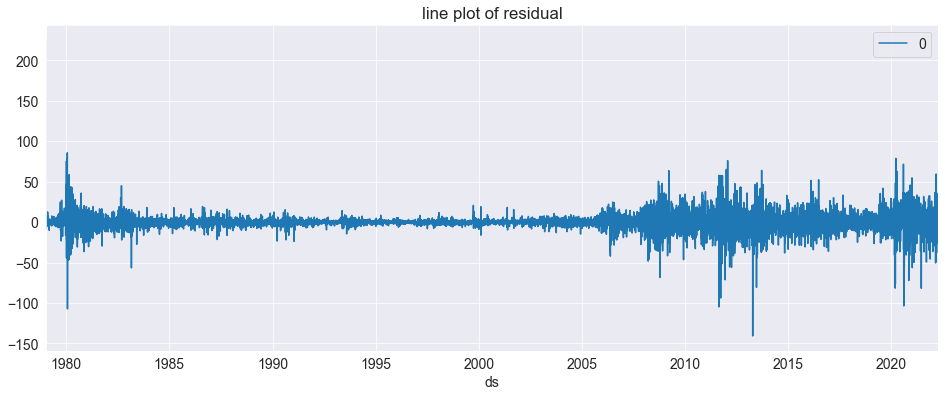

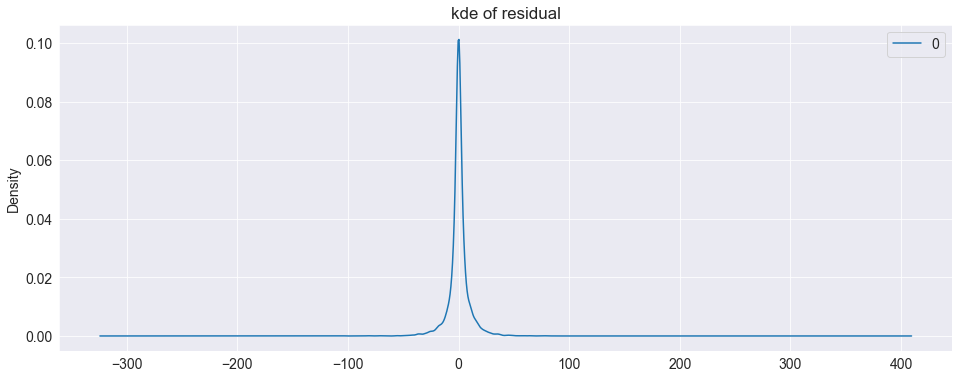

                  0
count  11296.000000
mean       0.198895
std        9.970360
min     -140.844121
25%       -2.394581
50%        0.048896
75%        2.783754
max      226.000000


In [122]:
# line plot of residuals
residuals = pd.DataFrame(arima_model_fit.resid)
residuals.plot()
plt.title("line plot of residual")
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.title('kde of residual')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [132]:
output_arima = arima_model_fit.predict(end=len(df)+365*2)

<AxesSubplot:>

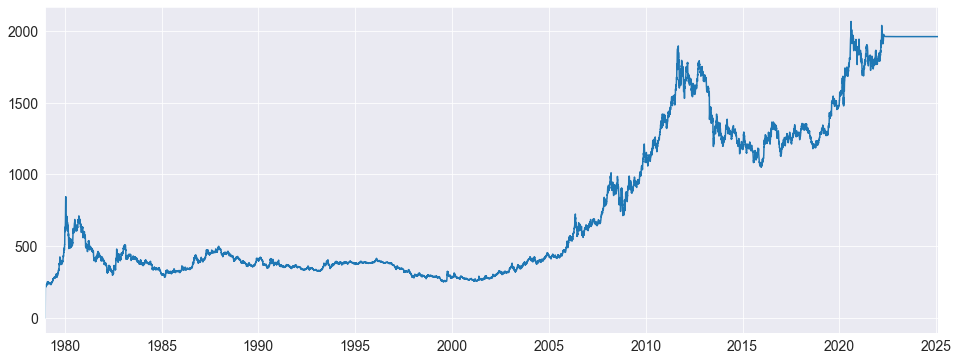

In [134]:
output_arima.plot()